# 1. Loading dependencies & datasets

In [218]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [219]:
telecom_df = pd.read_csv("../../datasets/telecom-churn/train.csv")
unseen_telecom_df = pd.read_csv("../../datasets/telecom-churn/test.csv")
sample_df = pd.read_csv("../../datasets/telecom-churn/sample.csv")
data_dict_df = pd.read_csv("../../datasets/telecom-churn/data_dictionary.csv")

print(telecom_df.shape)
print(unseen_telecom_df.shape)
print(sample_df.shape)
print(data_dict_df.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [220]:
telecom_df.info(verbose=True, show_counts=True)
print('Number of rows are: ', telecom_df.shape[0])
print('Number of cols are: ', telecom_df.shape[1])
print('Number of duplicated rows are: ', telecom_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

# 2. Data Preparation

## 2.1 Dropping columns with all NULL Values

In [221]:
all_null_value_cols = [col for col in telecom_df.columns if telecom_df[col].isnull().all() == True]
unseen_all_null_value_cols = [col for col in unseen_telecom_df.columns if unseen_telecom_df[col].isnull().all() == True]

print('Columns with all null values are:', all_null_value_cols)
print('Number of columns with all null values are: ', len(all_null_value_cols))

print('Columns with all null values in unseen data are:', unseen_all_null_value_cols)
print('Number of columns with all null values in unseen data are: ', len(unseen_all_null_value_cols))

Columns with all null values are: []
Number of columns with all null values are:  0
Columns with all null values in unseen data are: []
Number of columns with all null values in unseen data are:  0


##### Dropping columns with SINGLE Values

In [222]:
single_value_cols = []
for col in telecom_df.columns:
    if telecom_df[col].nunique() == 1:
        single_value_cols.append(col)
print('Columns with single value: ', single_value_cols)
print('Number of columns with sigle values are: ', len(single_value_cols))
telecom_df = telecom_df.drop(telecom_df[single_value_cols], axis = 1)
unseen_telecom_df = unseen_telecom_df.drop(unseen_telecom_df[single_value_cols], axis = 1)
print('Dropped all the columns with single values in available data. Shape now is: ', telecom_df.shape)
print('Dropped all the columns with single values in unseen data. Shape now is: ', unseen_telecom_df.shape)

Columns with single value:  ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']
Number of columns with sigle values are:  13
Dropped all the columns with single values in available data. Shape now is:  (69999, 159)
Dropped all the columns with single values in unseen data. Shape now is:  (30000, 158)


#### Dropping the id column

In [223]:
telecom_df = telecom_df.drop(columns=['id'])
print('Dropped the id column in available data. Shape now is: ',telecom_df.shape)

Dropped the id column in available data. Shape now is:  (69999, 158)


## 2.2 Imputing columns where NULL values are more than 70%

In [224]:
def calculate_null_values(telecom_df):
    null_percentages = (telecom_df.isnull().sum() / telecom_df.shape[0]) * 100
    null_values_df = pd.DataFrame({'Column Name': null_percentages.index, 'Null Percentage': null_percentages})
    null_values_df = null_values_df.loc[null_values_df['Null Percentage'] != 0.00]
    return null_values_df

In [225]:
null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)
print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Number of columns with NON-ZERO null values in available data:  (114, 2)
Number of columns with NON-ZERO null values in unseen data:  (114, 2)


In [226]:
print('Columns with Null Percentage greater than 70.00')
null_values_df[null_values_df['Null Percentage'] > 70.00]

Columns with Null Percentage greater than 70.00


,Column Name,Null Percentage
date_of_last_rech_data_6,date_of_last_rech_data_6,74.902499
date_of_last_rech_data_7,date_of_last_rech_data_7,74.478207
date_of_last_rech_data_8,date_of_last_rech_data_8,73.689624
total_rech_data_6,total_rech_data_6,74.902499
total_rech_data_7,total_rech_data_7,74.478207
total_rech_data_8,total_rech_data_8,73.689624
max_rech_data_6,max_rech_data_6,74.902499
max_rech_data_7,max_rech_data_7,74.478207
max_rech_data_8,max_rech_data_8,73.689624
count_rech_2g_6,count_rech_2g_6,74.902499


In [227]:
print('Removing the date columns with null values as they are not useful')
null_date_columns = [
    'date_of_last_rech_data_6',
    'date_of_last_rech_data_7',
    'date_of_last_rech_data_8',
    'date_of_last_rech_6',
    'date_of_last_rech_7',
    'date_of_last_rech_8'
]
telecom_df = telecom_df.drop(null_date_columns, axis = 1)
unseen_telecom_df = unseen_telecom_df.drop(null_date_columns, axis = 1)
null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)
print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Removing the date columns with null values as they are not useful
Number of columns with NON-ZERO null values in available data:  (108, 2)
Number of columns with NON-ZERO null values in unseen data:  (108, 2)


In [228]:
print('Imputing the categorical columns with appropriate values')
null_cat_columns = [
    'night_pck_user_6',
    'night_pck_user_7',
    'night_pck_user_8',
    'fb_user_6',
    'fb_user_7',
    'fb_user_8',
]
telecom_df[null_cat_columns] = telecom_df[null_cat_columns].fillna(-1).astype('category')
unseen_telecom_df[null_cat_columns] = unseen_telecom_df[null_cat_columns].fillna(-1).astype('category')
null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)
print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Imputing the categorical columns with appropriate values
Number of columns with NON-ZERO null values in available data:  (102, 2)
Number of columns with NON-ZERO null values in unseen data:  (102, 2)


In [229]:
print('Imputing the numerical columns with null values')
null_num_columns = null_values_df[null_values_df['Null Percentage'] > 70.00]['Column Name'].tolist()
telecom_df[null_num_columns] = telecom_df[null_num_columns].fillna(0.0)
unseen_telecom_df[null_num_columns] = unseen_telecom_df[null_num_columns].fillna(0.0)
null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)
print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Imputing the numerical columns with null values
Number of columns with NON-ZERO null values in available data:  (81, 2)
Number of columns with NON-ZERO null values in unseen data:  (81, 2)


## 2.3 Imputing remaining columns with NULL values using SimpleImputer

In [230]:
print('Imputing the columns with NAN values using Simple Imputer')
imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
#imputer = KNNImputer(n_neighbors = 5)
telecom_df[null_values_df['Column Name']] = imputer.fit_transform(telecom_df[null_values_df['Column Name']])
unseen_telecom_df[unseen_null_values_df['Column Name']] = imputer.fit_transform(unseen_telecom_df[unseen_null_values_df['Column Name']])  

null_values_df = calculate_null_values(telecom_df)
unseen_null_values_df = calculate_null_values(unseen_telecom_df)

print('Number of columns with NON-ZERO null values in available data: ',null_values_df.shape)
print('Number of columns with NON-ZERO null values in unseen data: ',unseen_null_values_df.shape)

Imputing the columns with NAN values using Simple Imputer
Number of columns with NON-ZERO null values in available data:  (0, 2)
Number of columns with NON-ZERO null values in unseen data:  (0, 2)


## 2.4 Deriving new columns

In [231]:
print('Deriving total value columns for available data:')
telecom_df['total_rech_data_amt_6'] = telecom_df['total_rech_data_6'] * telecom_df['av_rech_amt_data_6']
telecom_df['total_rech_data_amt_7'] = telecom_df['total_rech_data_7'] * telecom_df['av_rech_amt_data_7']
telecom_df['total_rech_data_amt_8'] = telecom_df['total_rech_data_8'] * telecom_df['av_rech_amt_data_8']

telecom_df['total_amt_6'] = telecom_df['total_rech_amt_6'] + telecom_df['total_rech_data_amt_6']
telecom_df['total_amt_7'] = telecom_df['total_rech_amt_7'] + telecom_df['total_rech_data_amt_7']
telecom_df['total_amt_8'] = telecom_df['total_rech_amt_8'] + telecom_df['total_rech_data_amt_8']

telecom_df['total_value'] = telecom_df['total_amt_6'] + telecom_df['total_amt_7']

print('Deriving total value columns for unseen data:')
unseen_telecom_df['total_rech_data_amt_6'] = unseen_telecom_df['total_rech_data_6'] * unseen_telecom_df['av_rech_amt_data_6']
unseen_telecom_df['total_rech_data_amt_7'] = unseen_telecom_df['total_rech_data_7'] * unseen_telecom_df['av_rech_amt_data_7']
unseen_telecom_df['total_rech_data_amt_8'] = unseen_telecom_df['total_rech_data_8'] * unseen_telecom_df['av_rech_amt_data_8']

unseen_telecom_df['total_amt_6'] = unseen_telecom_df['total_rech_amt_6'] + unseen_telecom_df['total_rech_data_amt_6']
unseen_telecom_df['total_amt_7'] = unseen_telecom_df['total_rech_amt_7'] + unseen_telecom_df['total_rech_data_amt_7']
unseen_telecom_df['total_amt_8'] = unseen_telecom_df['total_rech_amt_8'] + unseen_telecom_df['total_rech_data_amt_8']

unseen_telecom_df['total_value'] = unseen_telecom_df['total_amt_6'] + unseen_telecom_df['total_amt_7']

Deriving total value columns for available data:
Deriving total value columns for unseen data:


## 2.5 Creating Dummy Values for Categorical Columns

In [232]:
cat_dummies_df = pd.get_dummies(telecom_df[null_cat_columns], drop_first = True, dtype = 'int')
unseen_cat_dummies_df = pd.get_dummies(unseen_telecom_df[null_cat_columns], drop_first = True, dtype = 'int')
telecom_df = pd.concat([telecom_df, cat_dummies_df], axis=1)
unseen_telecom_df = pd.concat([unseen_telecom_df, unseen_cat_dummies_df], axis=1)
telecom_df['churn_probability'] = telecom_df['churn_probability'].astype('category')

## 2.6 Filtering input for high-profile customers

In [233]:
high_value_telecom_df = telecom_df[(telecom_df['total_value'] > telecom_df['total_value'].quantile(0.75))].copy()
unseen_high_value_telecom_df = unseen_telecom_df[(unseen_telecom_df['total_value'] > unseen_telecom_df['total_value'].quantile(0.75))].copy()

print('Filtered high value customers from available data. Shape now is: ',high_value_telecom_df.shape)
print('Filtered high value customers from unseen data. Shape now is: ',unseen_high_value_telecom_df.shape)

Filtered high value customers from available data. Shape now is:  (17495, 171)
Filtered high value customers from unseen data. Shape now is:  (7499, 171)


# 3. Model Building

## 3.1 Perform the Test Train Split

In [ ]:
print('Splitting the input values (X) and output values (y) from the Input Dataset.')
X = high_value_telecom_df.drop(['churn_probability'], axis=1)
y = high_value_telecom_df['churn_probability']
X_unseen = unseen_high_value_telecom_df
X_unseen_id = X_unseen.pop(('id'))

Splitting the input values (X) and output values (y) from the Input Dataset.


In [235]:
print('Splitting the input values (X) and output values (y) into the Train/Test Dataset.')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

Splitting the input values (X) and output values (y) into the Train/Test Dataset.


In [236]:
# Checking the shape after split
print('Train X Shape: ', X_train.shape)
print('Test X Shape: ', X_test.shape)
print('Unseen X Shape: ', X_unseen.shape)
print('Train y Shape: ', y_train.shape)
print('Test y Shape: ', y_test.shape)

Train X Shape:  (13996, 170)
Test X Shape:  (3499, 170)
Unseen X Shape:  (7499, 171)
Train y Shape:  (13996,)
Test y Shape:  (3499,)


In [237]:
print('Performing scaling on the Train, Test and Unseen data using MinMaxScaler')
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_unseen_scaled = scaler.transform(X_unseen)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_unseen_scaled = pd.DataFrame(X_unseen_scaled, columns = X_unseen.columns)

Performing scaling on the Train, Test and Unseen data using MinMaxScaler


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- id


In [ ]:
logistic_regression = LogisticRegression()
rfe_selector = RFE(logistic_regression, n_features_to_select = 20)
rfe_selector.fit(X_train_scaled, y_train)
selected_features = X_train_scaled.columns[rfe_selector.support_]

In [ ]:
X_train_scaled_selected = X_train_scaled[selected_features]
X_test_scaled_selected = X_test_scaled[selected_features]
X_unseen_scaled_selected = X_unseen_scaled[selected_features]

In [ ]:
print('Train X Shape: ', X_train_scaled_selected.shape)
print('Test X Shape: ', X_test_scaled_selected.shape)
print('Unseen X Shape: ', X_unseen_scaled_selected.shape)
print('Train y Shape: ', y_train.shape)
print('Test y Shape: ', y_test.shape)

Train X Shape:  (13996, 20)
Test X Shape:  (3499, 20)
Unseen X Shape:  (7499, 20)
Train y Shape:  (13996,)
Test y Shape:  (3499,)


In [ ]:
logistic_regression.fit(X_train_scaled_selected, y_train)
y_train_pred = logistic_regression.predict(X_train_scaled_selected)
train_score = logistic_regression.score(X_train_scaled_selected, y_train)

In [ ]:
y_test_pred = logistic_regression.predict(X_test_scaled_selected)
test_score = logistic_regression.score(X_test_scaled_selected, y_test)

Train accuracy: 91.91
Test accuracy: 92.37


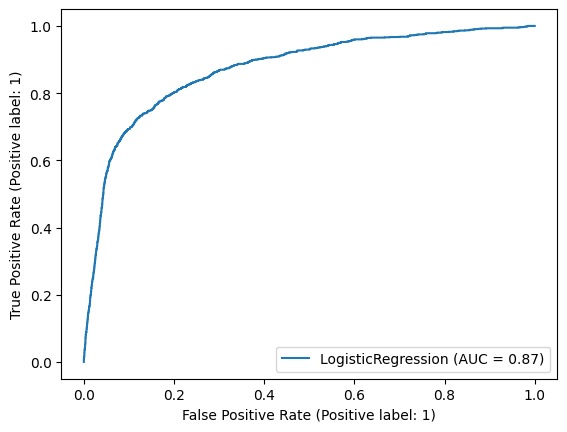

In [ ]:
print("Train accuracy:", round(train_score * 100, ndigits=2))
print("Test accuracy:", round(test_score * 100, ndigits=2))
logistic_regression_auc = RocCurveDisplay.from_estimator(logistic_regression, X_train_scaled_selected, y_train)

In [ ]:
unseen_telecom_lr_df = unseen_telecom_df.copy()
submission_data = unseen_telecom_lr_df[selected_features]
unseen_telecom_lr_df['churn_probability'] = logistic_regression.predict(submission_data)
output = unseen_telecom_lr_df[['id','churn_probability']]
output.to_csv('submission_lr.csv',index=False)

Train accuracy:  1.0
Test accuracy:  0.9136896256073164


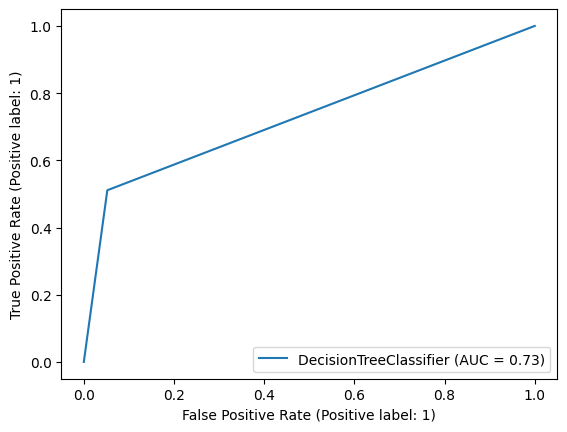

In [ ]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train_scaled, y_train)
y_train_pred_dtc = decision_tree_classifier.predict(X_train_scaled)
y_test_pred_dtc = decision_tree_classifier.predict(X_test_scaled)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred_dtc))
print("Test accuracy: ", accuracy_score(y_test, y_test_pred_dtc))
logistic_regression_auc = RocCurveDisplay.from_estimator(decision_tree_classifier, X_test_scaled, y_test)

In [ ]:
unseen_telecom_dtc_df = unseen_telecom_df.copy()
unseen_telecom_dtc_id_df = unseen_telecom_dtc_df.pop('id')
unseen_telecom_dtc_df['churn_probability'] = decision_tree_classifier.predict(unseen_telecom_dtc_df)
unseen_telecom_dtc_df = pd.concat([unseen_telecom_dtc_id_df, unseen_telecom_dtc_df], axis = 1)
output = unseen_telecom_dtc_df[['id','churn_probability']]
output.to_csv('submission_dtc.csv',index=False)

In [ ]:
decision_tree_classifier_gridcv = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search_classifier = GridSearchCV(estimator = decision_tree_classifier_gridcv, 
                           param_grid = params, 
                           cv = 4, n_jobs = -1, verbose = 1, scoring = "accuracy")

grid_search_classifier.fit(X_train_scaled, y_train)
grid_search_model = grid_search_classifier.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


Train accuracy:  1.0
Train accuracy:  0.9136896256073164


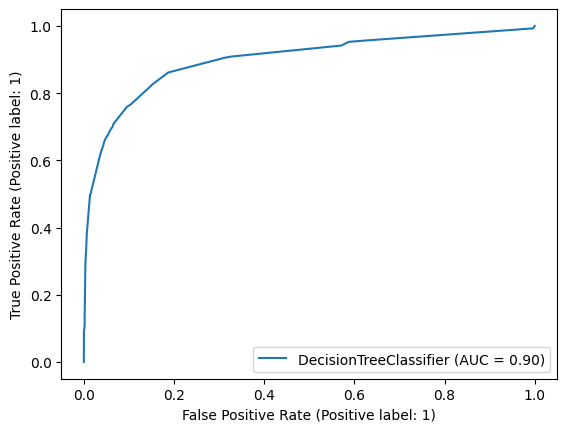

In [ ]:
y_train_pred_dtc_gridcv = grid_search_model.predict(X_train_scaled)
y_test_pred_dtc_gridcv = grid_search_model.predict(X_test_scaled)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred_dtc))
print("Train accuracy: ", accuracy_score(y_test, y_test_pred_dtc))
logistic_regression_auc = RocCurveDisplay.from_estimator(grid_search_model, X_test_scaled, y_test)

In [ ]:
unseen_telecom_dtc_gridcv_df = unseen_telecom_df.copy()

unseen_telecom_dtc_gridcv_id_df = unseen_telecom_dtc_gridcv_df.pop('id')
unseen_telecom_dtc_gridcv_df['churn_probability'] = grid_search_model.predict(unseen_telecom_dtc_gridcv_df)
unseen_telecom_dtc_gridcv_df = pd.concat([unseen_telecom_dtc_gridcv_id_df, unseen_telecom_dtc_gridcv_df], axis = 1)
output = unseen_telecom_dtc_gridcv_df[['id','churn_probability']]
output.to_csv('submission_dtc_gridcv.csv',index=False)

Train accuracy:  0.9447699342669335
Train accuracy:  0.9434124035438697


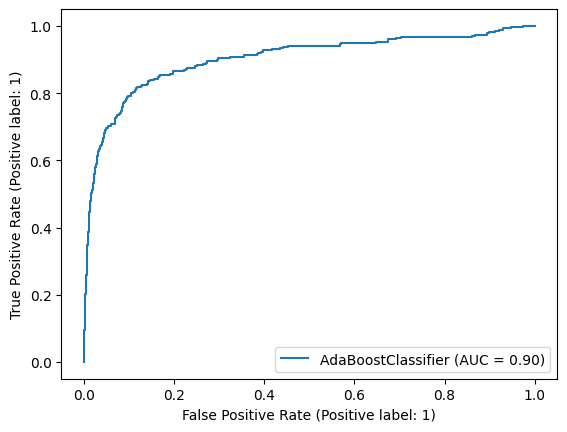

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_classifier = AdaBoostClassifier(n_estimators=200, random_state=1)

adaboost_classifier.fit(X_train_scaled, y_train)
y_train_pred_adaboost = adaboost_classifier.predict(X_train_scaled)
y_test_pred_adaboost = adaboost_classifier.predict(X_test_scaled)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred_adaboost))
print("Train accuracy: ", accuracy_score(y_test, y_test_pred_adaboost))
logistic_regression_auc = RocCurveDisplay.from_estimator(adaboost_classifier, X_test_scaled, y_test)

In [ ]:
unseen_telecom_adaboost_df = unseen_telecom_df.copy()
unseen_telecom_adaboost_id_df = unseen_telecom_adaboost_df.pop('id')
unseen_telecom_adaboost_df['churn_probability'] = adaboost_classifier.predict(unseen_telecom_adaboost_df)
unseen_telecom_adaboost_df = pd.concat([unseen_telecom_adaboost_id_df, unseen_telecom_adaboost_df], axis = 1)
output = unseen_telecom_adaboost_df[['id','churn_probability']]
output.to_csv('submission_adaboost.csv',index=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest_classifier_gridcv = RandomForestClassifier(n_estimators = 10, max_depth = 4, max_features = 5, random_state = 100)
params = {
    'max_depth': [2, 3, 5, 10 , 20, 50],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'n_estimators': [10, 25, 50, 100]
}
grid_search_classifier = GridSearchCV(estimator = random_forest_classifier_gridcv, 
                                      param_grid = params, 
                                      cv = 4, 
                                      n_jobs = -1, 
                                      verbose = 1, 
                                      scoring = "accuracy")

grid_search_classifier.fit(X_train_scaled, y_train)
grid_search_model = grid_search_classifier.best_estimator_

Fitting 4 folds for each of 144 candidates, totalling 576 fits


Train accuracy:  0.950485853100886
Test accuracy:  0.9468419548442412


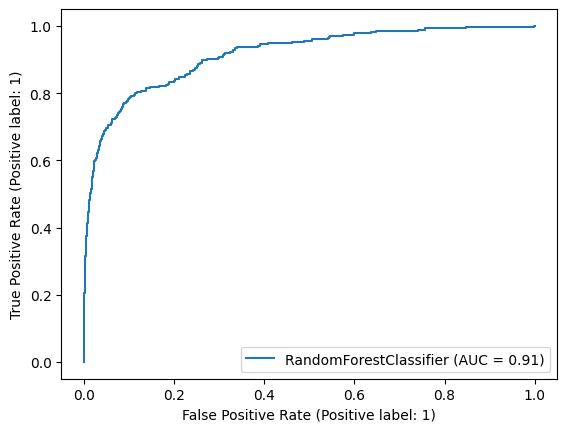

In [ ]:
y_train_pred_rf_gridcv = grid_search_model.predict(X_train_scaled)
y_test_pred_rf_gridcv = grid_search_model.predict(X_test_scaled)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred_rf_gridcv))
print("Test accuracy: ", accuracy_score(y_test, y_test_pred_rf_gridcv))
random_forest_classifier_auc = RocCurveDisplay.from_estimator(grid_search_model, X_test_scaled, y_test)

In [ ]:
unseen_telecom_random_forest_df = unseen_telecom_df.copy()
unseen_telecom_random_forest_id_df = unseen_telecom_random_forest_df.pop('id')
unseen_telecom_random_forest_df['churn_probability'] = grid_search_model.predict(unseen_telecom_random_forest_df)
unseen_telecom_random_forest_df = pd.concat([unseen_telecom_random_forest_id_df, unseen_telecom_random_forest_df], axis = 1)
output = unseen_telecom_random_forest_df[['id','churn_probability']]
output.to_csv('submission_random_forest_gridcv.csv',index=False)

In [ ]:
features_df = pd.DataFrame({
    "Varname": X_train_scaled.columns,
    "Imp": grid_search_model.feature_importances_
})
features_df.sort_values(by='Imp', ascending=False)

,Varname,Imp
80,total_ic_mou_8,0.049663
95,total_rech_amt_8,0.045708
156,total_amt_8,0.039529
2,arpu_8,0.037187
11,roam_ic_mou_8,0.036194
50,og_others_8,0.034559
53,total_og_mou_8,0.033074
14,roam_og_mou_8,0.031371
44,isd_og_mou_8,0.030229
8,offnet_mou_8,0.029493


Train accuracy:  1.0
Test accuracy:  0.9491283223778222


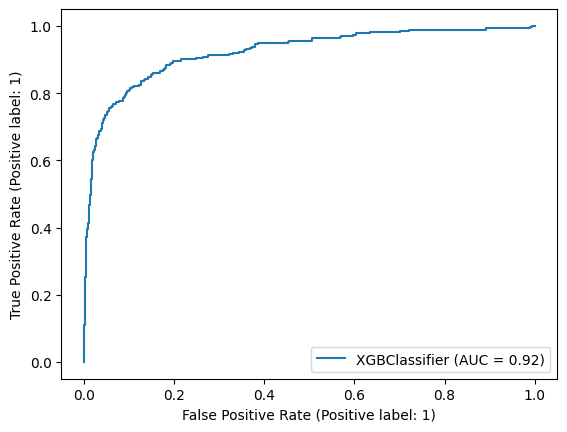

In [ ]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(n_jobs = -1, objective = 'binary:logistic') # default paramters
xgb_classifier.fit(X_train_scaled, y_train)
y_train_pred_xgb = xgb_classifier.predict(X_train_scaled)
y_test_pred_xgb = xgb_classifier.predict(X_test_scaled)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred_xgb))
print("Test accuracy: ", accuracy_score(y_test, y_test_pred_xgb))
xgb_classifier_auc = RocCurveDisplay.from_estimator(xgb_classifier, X_test_scaled, y_test)

In [ ]:
unseen_telecom_xgb_df = unseen_telecom_df.copy()
unseen_telecom_xgb_id_df = unseen_telecom_xgb_df.pop('id')
unseen_telecom_xgb_df['churn_probability'] = xgb_classifier.predict(unseen_telecom_xgb_df)
unseen_telecom_xgb_df = pd.concat([unseen_telecom_xgb_id_df, unseen_telecom_xgb_df], axis = 1)
output = unseen_telecom_xgb_df[['id','churn_probability']]
output.to_csv('submission_xgb.csv',index=False)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {
        'n_estimators' : [10, 20, 50, 100], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 3, 5, 10 , 20, 50]
        }

folds = 5
param_comb = 800
xgb_random_search_cv = RandomizedSearchCV(xgb_classifier, param_distributions = params, n_iter = param_comb, scoring = 'accuracy', n_jobs = -1, cv = 5, random_state = 42)
xgb_random_search_cv.fit(X_train_scaled, y_train)
xgb_random_search_cv_model = xgb_random_search_cv.best_estimator_
y_train_pred_xgb_random_search_cv = xgb_random_search_cv_model.predict(X_train_scaled)
y_test_pred_xgb_random_search_cv = xgb_random_search_cv_model.predict(X_test_scaled)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred_xgb_random_search_cv))
print("Test accuracy: ", accuracy_score(y_test, y_test_pred_xgb_random_search_cv))
xgb_random_search_cv_classifier_auc = RocCurveDisplay.from_estimator(xgb_random_search_cv_model, X_test_scaled, y_test)

KeyboardInterrupt: 

In [ ]:
unseen_telecom_xgb_random_search_cv_df = unseen_telecom_df.copy()
unseen_telecom_xgb_random_search_cv_id_df = unseen_telecom_xgb_random_search_cv_df.pop('id')
unseen_telecom_xgb_random_search_cv_df['churn_probability'] = xgb_random_search_cv_model.predict(unseen_telecom_xgb_random_search_cv_df)
unseen_telecom_xgb_random_search_cv_df = pd.concat([unseen_telecom_xgb_random_search_cv_id_df, unseen_telecom_xgb_random_search_cv_df], axis = 1)
output = unseen_telecom_xgb_random_search_cv_df[['id','churn_probability']]
output.to_csv('submission_xgb_random_search_cv.csv',index=False)

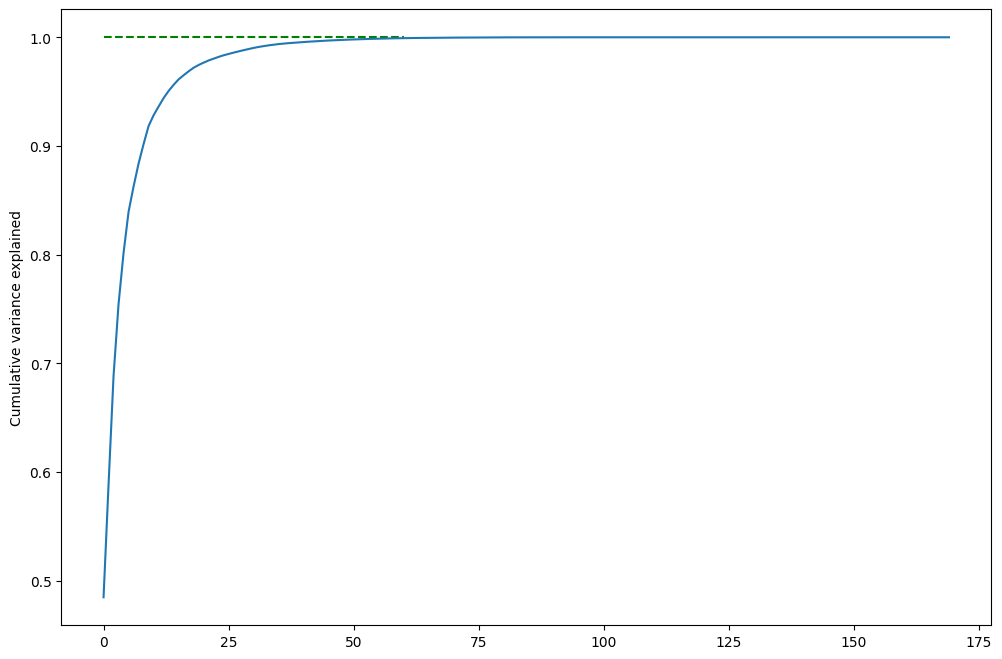

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42)
pca.fit(X_train)
pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=[12,8])
plt.hlines(y=1.00, xmax=60, xmin=0, colors="g", linestyles="--")
plt.plot(cumulative_variance_ratio)
plt.ylabel("Cumulative variance explained")
plt.show()

Train accuracy:  0.9607030580165762
Test accuracy:  0.9285510145755931


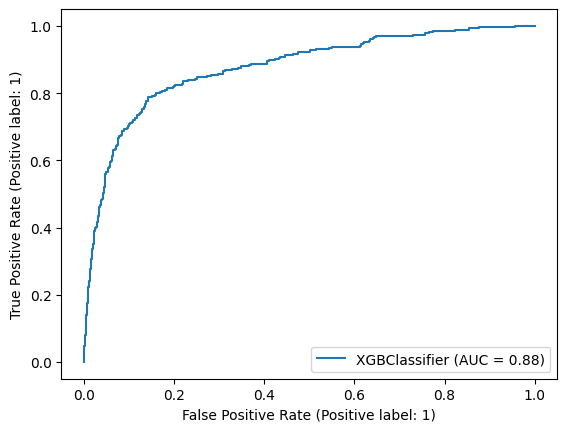

In [ ]:
from sklearn.decomposition import IncrementalPCA


pca = IncrementalPCA(n_components=20)
pca_with_components = pca
X_train_pca = pca_with_components.fit_transform(X_train)
X_test_pca = pca_with_components.transform(X_test)

logistic_regression_pca = xgb_random_search_cv_model
model_pca = logistic_regression_pca.fit(X_train_pca, y_train)
y_train_pred_pca = logistic_regression_pca.predict(X_train_pca)
y_test_pred_pca = logistic_regression_pca.predict(X_test_pca)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred_pca))
print("Test accuracy: ", accuracy_score(y_test, y_test_pred_pca))
logistic_regression_pca_auc = RocCurveDisplay.from_estimator(model_pca, X_test_pca, y_test)

In [ ]:
unseen_telecom_pca_df = unseen_telecom_df.copy()
unseen_telecom_pca_id_df = unseen_telecom_pca_df.pop('id')
unseen_telecom_pca_transformed_df = pca_with_components.transform(unseen_telecom_pca_df)
unseen_telecom_pca_df['churn_probability'] = logistic_regression_pca.predict(unseen_telecom_pca_transformed_df)
unseen_telecom_pca_df = pd.concat([unseen_telecom_pca_id_df, unseen_telecom_pca_df], axis = 1)
output = unseen_telecom_pca_df[['id','churn_probability']]
output.to_csv('submission_pcv.csv',index=False)